 ### --------------------------------------------------------------------
 ### Name:                     Phathutshedzo Tiny Mudau
 ### Student No:           22783352
 ### Module:                  MIT 805 (Big Data Processing) 
 ### Project: Assignment 2
 ### --------------------------------------------------------------------

## Description

<p style='text-align: justify;'>  The assignment is to use the Large Data frameworks and techniques that you learned in the course to address a real-world big data problem. Coding the MapReduce algorithm to extract and summarize the data as well as visualizing the dataset are specific tasks. A dataset between 3GB and 20GB in size is needed. Consequently, a dataset of previous loans from Lending Club was chosen. Loans were logged in this open-source dataset from Lending Club between 2007 and the third quarter of 2019. The data is available to download on the following website https://www.kaggle.com/denychaen/lending-club-loans-rejects-data. </p>

<p style='text-align: justify;'> According to market share, The Lending Club is one of the major peer-to-peer (P2P) lending platforms in the United States. Since the P2P market's start in 2007, it has expanded dramatically, sparking increased interest from consumers. With billions of dollars in annual loans made, there are large potential to profit from this alternative investment choice; however, it is still the investor's obligation to recognize the risks involved in the lending industry within this market. The goal of this project is to use big data techniques to extract data from extensive records of loans provided over the platform's operational years. The dataset includes 2,650,550 issued loans, each of which comprises 159 attributes. Due to the size of the dataset (3.47GB), processing it on a system with limited processing capability is challenging. The major goal of this project is to visualize numerous borrower characteristics in order to better understand distinct borrower characteristics in this market. Additionally, machine learning models will be used to predict the types of borrowers that are most likely to default on their loans.</p>

### Predictive Models using pyspark

In [1]:
import findspark
findspark.init()

# Spark session initailiser
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col, year, quarter, lit, to_date, to_timestamp, concat, avg
from pyspark.sql.types import DateType, TimestampType
from pyspark import SparkContext
from pyspark import SparkConf

# Machine Learning Packages
from pyspark.ml.feature import Imputer
from pyspark.sql import DataFrameStatFunctions as statFunc
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import IndexToString
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import PCA, IndexToString, StringIndexer, VectorIndexer, VectorSlicer
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve, auc

%matplotlib inline
#%matplotlib notebook 

import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib

# Force matplotlib to not use any Xwindows backend.
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats

import chart_studio.plotly as py #import plotly.plotly as py

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

import os
memory = '8g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args
#sc = SparkContext()  
SparkContext.setSystemProperty('spark.executor.memory', '8g')
SparkContext.setSystemProperty('spark.driver.memory', '8g')
spark_conf = SparkConf().setAll(pairs = [('spark.executor.memory', '8g'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])
spark = SparkSession.builder.master("local[*]").config(conf = spark_conf).appName("Lending-Club Loan Analysis using Pyspark").getOrCreate()
sqlContext = SQLContext(spark)

spark.sparkContext.setLogLevel('ERROR')

import warnings
warnings.filterwarnings('ignore')



C:\Users\PHATHUTSHEDZO\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



### Load the dataset

In [2]:
Loan_Data = spark.read.csv("file:///C:/Users/PHATHUTSHEDZO/Downloads/MIT805 ASSIGNMENT/Lending Club Data/Loan_2007-2019.csv", header=True, mode="DROPMALFORMED", inferSchema =True)

In [3]:
Loan_Data.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

In [4]:
print("Number of rows: {} and columns: {}".format(Loan_Data.count(),len(Loan_Data.columns)))

Number of rows: 2650550 and columns: 150


In [5]:
Loan_Data.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

In [6]:
print("Number of rows: {} and columns: {}".format(Loan_Data.count(),len(Loan_Data.columns)))

Number of rows: 2650550 and columns: 150


### Take into account the number of missing columns

In [7]:
# print Missing Values
def CheckMissingValues(df):
    df = df.rdd.flatMap(lambda r: r.asDict().items())
    return df.filter(lambda kv: kv[1] is None).mapValues(lambda x: 1).reduceByKey(lambda x,y: x+y).collect()

CheckMissingValues(Loan_Data)

[('member_id', 2650294),
 ('desc', 2524482),
 ('sec_app_open_act_il', 2486519),
 ('dti', 2658),
 ('purpose', 33),
 ('zip_code', 34),
 ('delinq_amnt', 62),
 ('mths_since_recent_bc', 77658),
 ('revol_util', 2319),
 ('open_rv_12m', 865907),
 ('pymnt_plan', 33),
 ('num_bc_tl', 70055),
 ('num_tl_90g_dpd_24m', 70055),
 ('tax_liens', 138),
 ('next_pymnt_d', 1385663),
 ('hardship_amount', 2639233),
 ('hardship_end_date', 2639233),
 ('mths_since_recent_bc_dlq', 2053744),
 ('title', 23358),
 ('grade', 33),
 ('issue_d', 33),
 ('last_fico_range_low', 33),
 ('tot_coll_amt', 70055),
 ('tot_cur_bal', 70055),
 ('mo_sin_rcnt_rev_tl_op', 70056),
 ('num_rev_tl_bal_gt_0', 70055),
 ('num_sats', 58369),
 ('tot_hi_cred_lim', 70055),
 ('total_bc_limit', 49809),
 ('debt_settlement_flag_date', 2615740),
 ('mths_since_recent_inq', 343053),
 ('emp_length', 181957),
 ('mo_sin_old_il_acct', 149639),
 ('percent_bc_gt_75', 79900),
 ('num_rev_accts', 70056),
 ('annual_inc', 37),
 ('total_rec_int', 33),
 ('num_actv_rev

### Find the feature columns which has more than 50% empty data

In [8]:
# find list of columns which has more than 50% of data missing.
def findMissingValueCols(df):
    missingValueColumns = []
    for column in df.columns:
        nullRows = df.where(col(column).isNull()).count()
        #print(column, "--", nullRows)
        if nullRows > df.count()*0.5 : # i.e. if ALL values are NULL
            missingValueColumns.append(column)
    return missingValueColumns

# columns names which has more than 50% data missing
missingValueColList = findMissingValueCols(Loan_Data)
print(missingValueColList)

['member_id', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'set

### Cleaning up the data

In [9]:
######### 1. Removing all the features which has more than 50% of the data empty ##########
Loan_Filtered = Loan_Data.drop(*missingValueColList)

######### 2. Removing unique ID and url columns ##########
Loan_Filtered = Loan_Filtered.drop("id", "issue_d","url")


######### 3. Removing Other insignificant columns ########## 
# application_type has only INDIVIDUAL, can be removed. 
# pymnt_plan & initial_list_status has only one category "n" & "f". Keeping state feature instead of zip_code.
# removing date fileds as well. policy_code has only one category "1"
Loan_Filtered = Loan_Filtered.drop("emp_title", "title", "zip_code", "earliest_cr_line", "last_pymnt_d", 
                                     "next_pymnt_d", "last_credit_pull_d", "policy_code" )


######### 4. Missing data imputation for tot_cur_bal ########## 
# 90% of the missing data in "tot_cur_bal", "tot_coll_amt" column can be filled with 0 since their loan status is "Fully Paid" OR "Charged Off"
Loan_Filtered = Loan_Filtered.withColumn("tot_cur_bal", when((col("tot_cur_bal").isNull() & 
                                                               col("loan_status").isin("Fully Paid", "Charged Off")), lit("0"))
                                          .otherwise(col("tot_cur_bal")))

Loan_Filtered = Loan_Filtered.withColumn("tot_coll_amt", when((col("tot_coll_amt").isNull() & 
                                                               col("loan_status").isin("Fully Paid", "Charged Off")), lit("0"))
                                          .otherwise(col("tot_coll_amt")))

# Inputing mean value for "total_rev_hi_lim"
mean = int(Loan_Filtered.select(avg("total_rev_hi_lim")).take(1)[0][0])
Loan_Filtered= Loan_Filtered.withColumn("total_rev_hi_lim", when(col("total_rev_hi_lim").isNull(), lit(mean))
                                           .otherwise(col("total_rev_hi_lim")))

######### 5. Removing loan observations which still have missing data. (~ 0.8% records) ##########
#print("Total Loan Observations - ", loanDFForModel.count())
Loan_Filtered= Loan_Filtered.dropna(how="any") 



######### 6. Adding the lable column to dataframe. 1- defalut and 0-paid/current ##########
Loan_Filtered = Loan_Filtered.withColumn("isDefault", when(col("loan_status").isin("Default","Charged Off", "Late (31-120 days)", "Late (16-30 days)", 
                                                                     "Does not meet the credit policy. Status:Charged Off"), 1)
                           .otherwise(0))

######### 7. Changing the feature datatype from string to numeric ########## 
Loan_Filtered = Loan_Filtered.withColumn("loan_amnt",Loan_Filtered["loan_amnt"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("funded_amnt",Loan_Filtered["funded_amnt"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("funded_amnt_inv",Loan_Filtered["funded_amnt_inv"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("int_rate",Loan_Filtered["int_rate"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("installment",Loan_Filtered["installment"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("annual_inc",Loan_Filtered["annual_inc"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("dti",Loan_Filtered["dti"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("delinq_2yrs",Loan_Filtered["delinq_2yrs"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("inq_last_6mths",Loan_Filtered["inq_last_6mths"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("open_acc",Loan_Filtered["open_acc"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("pub_rec",Loan_Filtered["pub_rec"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("revol_bal",Loan_Filtered["revol_bal"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("revol_util",Loan_Filtered["revol_util"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("total_acc",Loan_Filtered["total_acc"].cast('float'))
Loan_Filtered = Loan_Filtered.withColumn("fico_range_high",Loan_Filtered["fico_range_high"].cast('float').alias("fico_range_high"))
Loan_Filtered = Loan_Filtered.withColumn("last_fico_range_low",Loan_Filtered["last_fico_range_low"].cast('float').alias("last_fico_range_low"))
Loan_Filtered = Loan_Filtered.withColumn("open_acc_6m",Loan_Filtered["open_acc_6m"].cast('float').alias("open_acc_6m"))
Loan_Filtered = Loan_Filtered.withColumn("open_act_il",Loan_Filtered["open_act_il"].cast('float').alias("open_act_il"))
Loan_Filtered = Loan_Filtered.withColumn("open_il_12m",Loan_Filtered["open_il_12m"].cast('float').alias("open_il_12m"))
Loan_Filtered = Loan_Filtered.withColumn("open_il_24m",Loan_Filtered["open_il_24m"].cast('float').alias("open_il_24m"))
Loan_Filtered = Loan_Filtered.withColumn("mths_since_rcnt_il",Loan_Filtered["mths_since_rcnt_il"].cast('float').alias("mths_since_rcnt_il"))
Loan_Filtered = Loan_Filtered.withColumn("total_bal_il",Loan_Filtered["total_bal_il"].cast('float').alias("total_bal_il"))
Loan_Filtered = Loan_Filtered.withColumn("il_util",Loan_Filtered["il_util"].cast('float').alias("il_util"))
Loan_Filtered = Loan_Filtered.withColumn("open_rv_12m",Loan_Filtered["open_rv_12m"].cast('float').alias("open_rv_12m"))
Loan_Filtered = Loan_Filtered.withColumn("open_rv_24m",Loan_Filtered["open_rv_24m"].cast('float').alias("open_rv_24m"))
Loan_Filtered = Loan_Filtered.withColumn("max_bal_bc",Loan_Filtered["max_bal_bc"].cast('float').alias("max_bal_bc"))
Loan_Filtered = Loan_Filtered.withColumn("all_util",Loan_Filtered["all_util"].cast('float').alias("all_util"))
Loan_Filtered = Loan_Filtered.withColumn("inq_fi",Loan_Filtered["inq_fi"].cast('float').alias("inq_fi"))
Loan_Filtered = Loan_Filtered.withColumn("total_cu_tl",Loan_Filtered["total_cu_tl"].cast('float').alias("total_cu_tl"))
Loan_Filtered = Loan_Filtered.withColumn("avg_cur_bal",Loan_Filtered["avg_cur_bal"].cast('float').alias("avg_cur_bal"))
Loan_Filtered = Loan_Filtered.withColumn("bc_util",Loan_Filtered["bc_util"].cast('float').alias("bc_util"))


######### 8. Removing the fileds which are related to the current loan ########## 
Loan_Filtered  =Loan_Filtered.drop("out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", 
                                     "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee",
                                    "last_pymnt_amnt", "collections_12_mths_ex_med", "acc_now_delinq", "tot_coll_amt",
                                    "tot_cur_bal", "total_rev_hi_lim")

In [10]:
Loan_Filtered.printSchema()

root
 |-- loan_amnt: float (nullable = true)
 |-- funded_amnt: float (nullable = true)
 |-- funded_amnt_inv: float (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: float (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: float (nullable = true)
 |-- fico_range_low: string (nullable = true)
 |-- fico_range_high: float (nullable = true)
 |-- inq_last_6mths: float (nullable = true)
 |-- open_acc: float (nullable = true)
 |-- pub_rec: float (nullable = true)
 |-- revol_bal: float (nullable = tr

## MapReduce algorithm to count the number of appearance of string features in the dataframe

In [11]:
# Mapreduce for counts of columns values in data frame
def ValueCounts(df, col):
    count = df.rdd.map(lambda row: (row[col], 1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: -x[1]).collect()
    return count

In [12]:
ValueCounts(Loan_Filtered, 'loan_status')

[('Current', 780353),
 ('Fully Paid', 317487),
 ('Charged Off', 85320),
 ('Late (31-120 days)', 16962),
 ('In Grace Period', 7333),
 ('Late (16-30 days)', 3371),
 ('Default', 27)]

This results shows that the dominating loans statust are `Fully Paid`, `Current` and `Charged-Off`. It is therefore not neccesary to keep all the loan status when building the model. Only these three loan status are worth keeping however the `current` loans are not interesting to investors as they need to know about the completed loans and those that are written-off. Therefore we filter the data to contain only charged off and paid up loans and encode the statuse with bolean values (`True` for charged off and `False` for paid up). 

In [13]:
def LoanStatusFilter(df):
    # = df.filter("loan_status == 'Fully Paid' or loan_status == 'Charged Off' ")
    return df.filter("loan_status == 'Fully Paid' or loan_status == 'Charged Off' ")

Loan_Filtered = LoanStatusFilter(Loan_Filtered)


In [16]:
ValueCounts(Loan_Filtered, 'loan_status')

[('Fully Paid', 317487), ('Charged Off', 85320)]

In [17]:
ValueCounts(Loan_Filtered, 'grade')

[('C', 121815),
 ('B', 114996),
 ('A', 68449),
 ('D', 60463),
 ('E', 24714),
 ('F', 8914),
 ('G', 3456)]

In [18]:
ValueCounts(Loan_Filtered, 'sub_grade')

[('B5', 27777),
 ('C1', 27404),
 ('B4', 24225),
 ('C5', 23930),
 ('C4', 23808),
 ('C2', 23711),
 ('C3', 22962),
 ('B3', 21655),
 ('B1', 20929),
 ('B2', 20410),
 ('A5', 16362),
 ('A1', 15003),
 ('D2', 14947),
 ('A4', 14641),
 ('D1', 14450),
 ('D3', 12293),
 ('A2', 11229),
 ('A3', 11214),
 ('D4', 10022),
 ('D5', 8751),
 ('E1', 5939),
 ('E2', 4925),
 ('E5', 4788),
 ('E3', 4736),
 ('E4', 4326),
 ('F1', 2773),
 ('F2', 1845),
 ('F3', 1668),
 ('F4', 1366),
 ('F5', 1262),
 ('G1', 1049),
 ('G2', 710),
 ('G3', 600),
 ('G4', 571),
 ('G5', 526)]

### Binary Encoding for Categorical Feature - "term", "initial_list_status", "application_type", "pymnt_plan

In [19]:
#These features have only two categories

indexer = StringIndexer(inputCol="term", outputCol="termIndex", handleInvalid="keep")
Loan_Filtered = indexer.fit(Loan_Filtered).transform(Loan_Filtered)

indexer = StringIndexer(inputCol="initial_list_status", outputCol="initial_list_statusIndex", handleInvalid="keep")
Loan_Filtered = indexer.fit(Loan_Filtered).transform(Loan_Filtered)

indexer = StringIndexer(inputCol="application_type", outputCol="application_typeIndex", handleInvalid="keep")
Loan_Filtered = indexer.fit(Loan_Filtered).transform(Loan_Filtered)

indexer = StringIndexer(inputCol="pymnt_plan", outputCol="pymnt_planIndex", handleInvalid="keep")
Loan_Filtered = indexer.fit(Loan_Filtered).transform(Loan_Filtered)


In [20]:
Loan_Filtered.show()

+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-----------+----------+------------------+----------+-----+-----------+--------------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+--------------------+-------------------+----------------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+------+-----------+------------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+----------------+------------+------------------+------------------+--------------+--

### One-Hot Encoding for Categorical Feature - "grade"¶

In [21]:
#categories = loanDFForModel.select("grade").distinct().rdd.flatMap(lambda x: x).collect()
categories = Loan_Filtered.select("grade").distinct().toPandas().grade.tolist()
#print(categories)
#print(type(categories))
exprs = [F.when(F.col("grade") == category, 1).otherwise(0).alias(category)
         for category in categories]

Loan_Filtered = Loan_Filtered.select("*", *exprs)

newCategories = []
for category in categories:
    Loan_Filtered = Loan_Filtered.withColumnRenamed(category, "grade_"+category)
    newCategories.append("grade_"+category)
print(newCategories)

['grade_F', 'grade_E', 'grade_B', 'grade_D', 'grade_C', 'grade_A', 'grade_G']


## One-Hot Encoding for Categorical Feature - "sub_grade"

In [22]:
categories = Loan_Filtered.select("sub_grade").distinct().toPandas().sub_grade.tolist()
exprs = [F.when(F.col("sub_grade") == category, 1).otherwise(0).alias(category)
         for category in categories]

Loan_Filtered = Loan_Filtered.select("*", *exprs)

newCategories = []
for category in categories:
    Loan_Filtered = Loan_Filtered.withColumnRenamed(category, "sub_grade_"+category)
    newCategories.append("sub_grade_"+category)
print(newCategories)

['sub_grade_D5', 'sub_grade_F2', 'sub_grade_B4', 'sub_grade_A2', 'sub_grade_E4', 'sub_grade_B2', 'sub_grade_C3', 'sub_grade_D1', 'sub_grade_C4', 'sub_grade_F1', 'sub_grade_D3', 'sub_grade_F5', 'sub_grade_G2', 'sub_grade_B1', 'sub_grade_B3', 'sub_grade_E5', 'sub_grade_C5', 'sub_grade_G3', 'sub_grade_A4', 'sub_grade_F4', 'sub_grade_B5', 'sub_grade_E3', 'sub_grade_G4', 'sub_grade_D2', 'sub_grade_C1', 'sub_grade_F3', 'sub_grade_A5', 'sub_grade_E1', 'sub_grade_C2', 'sub_grade_D4', 'sub_grade_E2', 'sub_grade_A3', 'sub_grade_G5', 'sub_grade_G1', 'sub_grade_A1']


### One-Hot Encoding for Categorical Feature - "home_ownership"

In [23]:
categories = Loan_Filtered.select("home_ownership").distinct().toPandas().home_ownership.tolist()
exprs = [F.when(F.col("home_ownership") == category, 1).otherwise(0).alias(category)
         for category in categories]

Loan_Filtered = Loan_Filtered.select("*", *exprs)

newCategories = []
for category in categories:
    Loan_Filtered = Loan_Filtered.withColumnRenamed(category, "home_ownership_"+category)
    newCategories.append("home_ownership_"+category)
print(newCategories)

['home_ownership_OWN', 'home_ownership_RENT', 'home_ownership_MORTGAGE', 'home_ownership_ANY', 'home_ownership_NONE']


### One-Hot Encoding for Categorical Feature - "verification_status"

In [24]:
categories = Loan_Filtered.select("verification_status").distinct().toPandas().verification_status.tolist()
#print(categories)
exprs = [F.when(F.col("verification_status") == category, 1).otherwise(0).alias(category)
         for category in categories]

Loan_Filtered = Loan_Filtered.select("*", *exprs)

newCategories = []
for category in categories:
    Loan_Filtered = Loan_Filtered.withColumnRenamed(category, "verification_status_"+category)
    newCategories.append("verification_status_"+category)
print(newCategories)

['verification_status_Verified', 'verification_status_Source Verified', 'verification_status_Not Verified']


### One-Hot Encoding for Categorical Feature - "purpose"

In [25]:
categories = Loan_Filtered.select("purpose").distinct().toPandas().purpose.tolist()
#print(categories)
exprs = [F.when(F.col("purpose") == category, 1).otherwise(0).alias(category)
         for category in categories]

Loan_Filtered = Loan_Filtered.select("*", *exprs)

newCategories = []
for category in categories:
    Loan_Filtered = Loan_Filtered.withColumnRenamed(category, "purpose_"+category)
    newCategories.append("purpose_"+category)
print(newCategories)

['purpose_other', 'purpose_small_business', 'purpose_debt_consolidation', 'purpose_credit_card', 'purpose_moving', 'purpose_vacation', 'purpose_renewable_energy', 'purpose_house', 'purpose_car', 'purpose_major_purchase', 'purpose_medical', 'purpose_home_improvement', 'purpose_wedding']


### One-Hot Encoding for Categorical Feature - "addr_state"

In [26]:
categories = Loan_Filtered.select("addr_state").distinct().toPandas().addr_state.tolist()
#print(categories)
exprs = [F.when(F.col("addr_state") == category, 1).otherwise(0).alias(category)
         for category in categories]

Loan_Filtered = Loan_Filtered.select("*", *exprs)

newCategories = []
for category in categories:
    Loan_Filtered = Loan_Filtered.withColumnRenamed(category, "addr_state_"+category)
    newCategories.append("addr_state_"+category)
print(newCategories)

['addr_state_SC', 'addr_state_AZ', 'addr_state_LA', 'addr_state_MN', 'addr_state_NJ', 'addr_state_DC', 'addr_state_OR', 'addr_state_VA', 'addr_state_RI', 'addr_state_KY', 'addr_state_WY', 'addr_state_NH', 'addr_state_MI', 'addr_state_NV', 'addr_state_WI', 'addr_state_CA', 'addr_state_NE', 'addr_state_CT', 'addr_state_MT', 'addr_state_NC', 'addr_state_VT', 'addr_state_MD', 'addr_state_DE', 'addr_state_MO', 'addr_state_IL', 'addr_state_ME', 'addr_state_WA', 'addr_state_ND', 'addr_state_MS', 'addr_state_AL', 'addr_state_IN', 'addr_state_OH', 'addr_state_TN', 'addr_state_NM', 'addr_state_PA', 'addr_state_SD', 'addr_state_NY', 'addr_state_TX', 'addr_state_WV', 'addr_state_GA', 'addr_state_MA', 'addr_state_KS', 'addr_state_FL', 'addr_state_CO', 'addr_state_AK', 'addr_state_AR', 'addr_state_OK', 'addr_state_UT', 'addr_state_HI', 'addr_state_ID']


In [27]:
Loan_Filtered.printSchema()

root
 |-- loan_amnt: float (nullable = true)
 |-- funded_amnt: float (nullable = true)
 |-- funded_amnt_inv: float (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: float (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: float (nullable = true)
 |-- fico_range_low: string (nullable = true)
 |-- fico_range_high: float (nullable = true)
 |-- inq_last_6mths: float (nullable = true)
 |-- open_acc: float (nullable = true)
 |-- pub_rec: float (nullable = true)
 |-- revol_bal: float (nullable = tr

### Converting Categorical feature "emp_lenght" to continous feature

In [28]:
Loan_Filtered = Loan_Filtered.withColumn("emp_lengthIndex", when(col("emp_length") == "< 1 year", 0)
                                           .when(col("emp_length") == "1 year", 1)
                                           .when(col("emp_length") == "2 years", 2)
                                           .when(col("emp_length") == "3 years", 3)
                                           .when(col("emp_length") == "4 years", 4)
                                           .when(col("emp_length") == "5 years", 5)
                                           .when(col("emp_length") == "6 years", 6)
                                           .when(col("emp_length") == "7 years", 7)
                                           .when(col("emp_length") == "8 years", 8)
                                           .when(col("emp_length") == "9 years", 9)
                                           .when(col("emp_length") == "10+ years", 10)
                                           .otherwise(0))

### Dropping categorical features after One-Hot encoding

In [29]:
# Remove the original categorical columns after encoding.
Loan_Filtered= Loan_Filtered.drop("term", "initial_list_status", "application_type", "pymnt_plan", "grade", "sub_grade", 
                                     "home_ownership", "verification_status", "purpose", "addr_state", "emp_length")

Loan_Filtered = Loan_Filtered.withColumn("ClassLable", col("isDefault"))
Loan_Filtered = Loan_Filtered.drop("isDefault")

Loan_Filtered.printSchema()

root
 |-- loan_amnt: float (nullable = true)
 |-- funded_amnt: float (nullable = true)
 |-- funded_amnt_inv: float (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: float (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: float (nullable = true)
 |-- fico_range_low: string (nullable = true)
 |-- fico_range_high: float (nullable = true)
 |-- inq_last_6mths: float (nullable = true)
 |-- open_acc: float (nullable = true)
 |-- pub_rec: float (nullable = true)
 |-- revol_bal: float (nullable = true)
 |-- revol_util: float (nullable = true)
 |-- total_acc: float (nullable = true)
 |-- last_fico_range_high: string (nullable = true)
 |-- last_fico_range_low: float (nullable = true)
 |-- open_acc_6m: float (nullable = true)
 |-- open_act_il: float (nullable = true)
 |-- open_il_12m: float (nullable = true)
 |-- open_il_24m: float (nullable = true)
 |-- mths_since_rcnt_

In [30]:
Loan_Filtered.groupby("ClassLable").count().show()

+----------+------+
|ClassLable| count|
+----------+------+
|         1| 85320|
|         0|317487|
+----------+------+



In [31]:
Defualt_Total = Loan_Filtered.groupby("ClassLable").count().toPandas()
Number_of_defaults = Defualt_Total['count'][0]
Total = Defualt_Total['count'][0] + Defualt_Total['count'][1]

In [32]:
# Adding a weight columns to the dataset to handel class imbalance (#Default Loans / #Total Loans)
balancingRatio  = Number_of_defaults/Total
print(balancingRatio)
Loan_Filtered = Loan_Filtered.withColumn("weightColumn", when(col("ClassLable") == 0, balancingRatio)
                                           .otherwise((1-balancingRatio)))

Loan_Filtered.groupby("weightColumn").count().show()

0.21181359807550515
+-------------------+------+
|       weightColumn| count|
+-------------------+------+
| 0.7881864019244949| 85320|
|0.21181359807550515|317487|
+-------------------+------+



In [33]:
Loan_Filtered = Loan_Filtered.drop("fico_range_low", "last_fico_range_high", "hardship_flag", "debt_settlement_flag","loan_status")

In [34]:
colList = Loan_Filtered.columns
print(colList)
print(len(colList))
colList.remove("ClassLable")
print(colList)
print(len(colList))

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_fico_range_low', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_

In [35]:
df = spark.read.csv("C:/Users/PHATHUTSHEDZO/Downloads/MIT805 ASSIGNMENT/Lending Club Data/Lending_Club_Clean_New.csv", header=True, mode="DROPMALFORMED", inferSchema =True)

In [36]:
#### Drop rows with conditions – where clause
data_2=df.where("ClassLable!=100")
data_2.show()

+---+---------+-----------+---------------+--------+-----------+----------+-----+-----------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+------+-----------+------------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+----------------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-----------------+--------------+--------------------------+---------+------------------------+---------------------+---------------+

In [37]:
# drop rows with id=1 
data_2.where(data_2.ClassLable !='100').show()

+---+---------+-----------+---------------+--------+-----------+----------+-----+-----------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+------+-----------+------------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+----------------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-----------------+--------------+--------------------------+---------+------------------------+---------------------+---------------+

In [38]:
data_2.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- fico_range_high: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- open_acc: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: double (nullable = true)
 |-- last_fico_range_low: double (nullable = true)
 |-- open_acc_6m: double (nullable = true)
 |-- open_act_il: double (nullable = true)
 |-- open_il_12m: double (nullable = true)
 |-- open_il_24m: double (nullable = true)
 |-- mths_since_rcnt_il: double (nullable = true)
 |-- total_bal_il: double (nullable = true)
 |-- il_util

In [39]:
data_2 = data_2.drop("_c0")

In [40]:
data_2.printSchema()

root
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- fico_range_high: double (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- open_acc: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: double (nullable = true)
 |-- last_fico_range_low: double (nullable = true)
 |-- open_acc_6m: double (nullable = true)
 |-- open_act_il: double (nullable = true)
 |-- open_il_12m: double (nullable = true)
 |-- open_il_24m: double (nullable = true)
 |-- mths_since_rcnt_il: double (nullable = true)
 |-- total_bal_il: double (nullable = true)
 |-- il_util: double (nullable = true)
 |-- open

In [41]:
data_2 = data_2.drop("label")

In [42]:
# drop rows with id less than 4
data_2.where(data_2.ClassLable>99).show()

+---------+-----------+---------------+--------+-----------+----------+---+-----------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+------+-----------+------------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+----------------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-----------------+--------------+--------------------------+---------+------------------------+---------------------+---------------+------

### Vectorizing feature columns

In [43]:
assembler = VectorAssembler(inputCols=[ *colList ], outputCol="features")

data_Trans = assembler.transform(data_2)

data_Trans.show(5)

+---------+-----------+---------------+--------+-----------+----------+-----+-----------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+------+-----------+------------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+----------------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-----------------+--------------+--------------------------+---------+------------------------+---------------------+---------------+----

### Creating LabelPoint, adding the class lable in transformed data

In [44]:
labelIndexer = StringIndexer(inputCol="ClassLable", outputCol="label", handleInvalid="keep")
data_Trans2 = labelIndexer.fit(data_Trans).transform(data_Trans)

data_Trans2.show(5)

+---------+-----------+---------------+--------+-----------+----------+-----+-----------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+------+-----------+------------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+----------------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-----------------+--------------+--------------------------+---------+------------------------+---------------------+---------------+----

### Train/Test split based on the hardcoded seed value (70 : 30)

In [45]:
# Creating Training and Test set (70% , 30%)
(trainingSetDF, testSetDF) = data_Trans2.randomSplit([0.7, 0.3], 1395)

trainingSetDF.cache()
testSetDF.cache()

DataFrame[loan_amnt: double, funded_amnt: double, funded_amnt_inv: double, int_rate: double, installment: double, annual_inc: double, dti: double, delinq_2yrs: double, fico_range_high: double, inq_last_6mths: double, open_acc: double, pub_rec: double, revol_bal: double, revol_util: double, total_acc: double, last_fico_range_low: double, open_acc_6m: double, open_act_il: double, open_il_12m: double, open_il_24m: double, mths_since_rcnt_il: double, total_bal_il: double, il_util: double, open_rv_12m: double, open_rv_24m: double, max_bal_bc: double, all_util: double, inq_fi: double, total_cu_tl: double, inq_last_12m: double, acc_open_past_24mths: double, avg_cur_bal: double, bc_open_to_buy: double, bc_util: double, chargeoff_within_12_mths: double, delinq_amnt: double, mo_sin_old_il_acct: double, mo_sin_old_rev_tl_op: double, mo_sin_rcnt_rev_tl_op: double, mo_sin_rcnt_tl: double, mort_acc: double, mths_since_recent_bc: double, mths_since_recent_inq: double, num_accts_ever_120_pd: double, n

In [46]:
trainingSetDF.count(), len(trainingSetDF.columns)

(282243, 187)

In [47]:
# drop rows with id=100 
data_2.where(data_2.ClassLable !='100').show()

+---------+-----------+---------------+--------+-----------+----------+-----+-----------+---------------+--------------+--------+-------+---------+----------+---------+-------------------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+------+-----------+------------+--------------------+-----------+--------------+-------+------------------------+-----------+------------------+--------------------+---------------------+--------------+--------+--------------------+---------------------+---------------------+--------------+---------------+-----------+---------+---------+-------------+-------------+-------------------+--------+----------------+------------+------------------+------------------+--------------+----------------+--------------------+---------+---------------+-----------------+--------------+--------------------------+---------+------------------------+---------------------+---------------+----

In [48]:
trainingSetDF.groupby("ClassLable").count().show()

+----------+------+
|ClassLable| count|
+----------+------+
|         1| 59912|
|         0|222331|
+----------+------+



### Feature Selection Using Random Forest

In [49]:
rf = RandomForestClassifier(labelCol="ClassLable", featuresCol="features",maxDepth=4, numTrees=30)
model = rf.fit(trainingSetDF)

In [50]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

importance = ExtractFeatureImp(model.featureImportances, trainingSetDF,"features")
#importance

#pd.set_option('dispaly.max_rows',None)
Selected_features = importance[importance['score']>=0.000100]
Best = Selected_features['idx'].values

In [51]:
Best = list(Best)

In [52]:
from pyspark.ml.linalg import Vectors
slicer = VectorSlicer(inputCol="features", outputCol="features2", indices=Best)
Final_Dataset = slicer.transform(data_Trans2)

In [53]:
# Creating Training and Test set (70% , 30%)
(trainingSetDF2, testSetDF2) = Final_Dataset.randomSplit([0.7, 0.3], 1395)

trainingSetDF2.cache()
testSetDF2.cache()

DataFrame[loan_amnt: double, funded_amnt: double, funded_amnt_inv: double, int_rate: double, installment: double, annual_inc: double, dti: double, delinq_2yrs: double, fico_range_high: double, inq_last_6mths: double, open_acc: double, pub_rec: double, revol_bal: double, revol_util: double, total_acc: double, last_fico_range_low: double, open_acc_6m: double, open_act_il: double, open_il_12m: double, open_il_24m: double, mths_since_rcnt_il: double, total_bal_il: double, il_util: double, open_rv_12m: double, open_rv_24m: double, max_bal_bc: double, all_util: double, inq_fi: double, total_cu_tl: double, inq_last_12m: double, acc_open_past_24mths: double, avg_cur_bal: double, bc_open_to_buy: double, bc_util: double, chargeoff_within_12_mths: double, delinq_amnt: double, mo_sin_old_il_acct: double, mo_sin_old_rev_tl_op: double, mo_sin_rcnt_rev_tl_op: double, mo_sin_rcnt_tl: double, mort_acc: double, mths_since_recent_bc: double, mths_since_recent_inq: double, num_accts_ever_120_pd: double, n

### Computing the model evaluation matrix

In [54]:
def getEvaluationMatrix(predicDF):
    lablePrediction = predicDF.select( "label", "prediction")
    lablePrediction.cache()
    totalCount = lablePrediction.count()
    correctCount = lablePrediction.filter(col("label") == col("prediction")).count()
    wrongCount = lablePrediction.filter(~(col("label") == col("prediction"))).count()
    trueP = lablePrediction.filter(col("label") == 0.0).filter(col("label") == col("prediction")).count()
    trueN = lablePrediction.filter(col("label") == 1.0).filter(col("label") == col("prediction")).count()
    falseN = lablePrediction.filter(col("label") == 1.0).filter(~(col("label") == col("prediction"))).count()
    falseP = lablePrediction.filter(col("label") == 0.0).filter(~(col("label") == col("prediction"))).count()

    ratioWrong = float(wrongCount) / float(totalCount) 
    ratioCorrect = float(correctCount)/ float(totalCount)

    print("totalCount   - ", totalCount)
    print("correctCount - ", correctCount)
    print("wrongCount   - ", wrongCount)
    print("trueP        - ", trueP)
    print("trueN        - ", trueN)
    print("falseN       - ", falseN)
    print("falseP       - ", falseP)
    print("ratioWrong   - ", ratioWrong)
    print("ratioCorrect - ", ratioCorrect)
    
    precision = ((float(trueP) / (float(trueP) + float(falseP))) * 100 )
    recall = ((float(trueP) / (float(trueP) + float(falseN))) * 100 )
    print("Accuracy     - ", (trueP + trueN) / totalCount)
    print("Precision    - ", precision)
    print("Recall       - ", recall)
    print("F-1 Score    - ", ((2* ( (precision*recall) / (precision + recall))) ))
    print("Sensitivity  - ", ((float(trueP) / (float(trueP) + float(falseN))) * 100 ))
    print("Specificity  - ", ((float(trueN) / (float(trueN) + float(falseP))) * 100 ))
    
    createROC(predictions)

### Computing the ROC Curve

In [55]:
def createROC(predictions):
    results = predictions.select(['probability', 'label'])
 
    ## prepare score-label set
    results_collect = results.collect()
    results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
    scoreAndLabels = spark.sparkContext.parallelize(results_list)
 
    bcMetrics = BinaryClassificationMetrics(scoreAndLabels)
    print("ROC score is - ", bcMetrics.areaUnderROC)
        
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
 
    y_test = [i[1] for i in results_list]
    y_score = [i[0] for i in results_list]
 
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
 
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### Logistics Regression Classifier

In [56]:
%matplotlib inline
print("**** Running Logistic Regression Classifier with best parameter found using ML pipeline **** ")

# Create initial LogisticRegression model
lr_classifier = LogisticRegression(labelCol="label", featuresCol="features", maxIter=3, weightCol="weightColumn")
#lr_classifier = LogisticRegression(labelCol="label", featuresCol="pcaFeatures", maxIter=10, weightCol="weightColumn")

# Train model with Training Data
lrModel = lr_classifier.fit(trainingSetDF)

# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testSetDF)

# Evaluate model
evaluator = MulticlassClassificationEvaluator( labelCol="label")
lr_accuracy = evaluator.evaluate(predictions)

#print(lr_accuracy)

**** Running Logistic Regression Classifier with best parameter found using ML pipeline **** 


totalCount   -  120300
correctCount -  118896
wrongCount   -  1404
trueP        -  93619
trueN        -  25277
falseN       -  74
falseP       -  1330
ratioWrong   -  0.011670822942643391
ratioCorrect -  0.9883291770573566
Accuracy     -  0.9883291770573566
Precision    -  98.59924801735669
Recall       -  99.92101864600343
F-1 Score    -  99.25573308171032
Sensitivity  -  99.92101864600343
Specificity  -  95.00131544330439
ROC score is -  0.9991843845005205


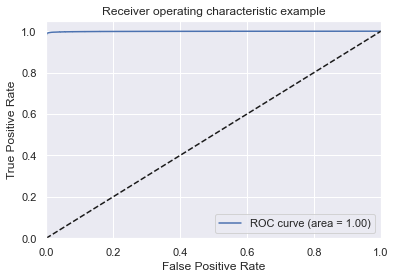

In [58]:
getEvaluationMatrix(predictions)

### NaiveBayes Classifier

**** Running NaiveBayes Classifier with best parameter found using ML pipeline **** 
totalCount   -  120300
correctCount -  63408
wrongCount   -  56892
trueP        -  46117
trueN        -  17291
falseN       -  8060
falseP       -  48832
ratioWrong   -  0.47291770573566083
ratioCorrect -  0.5270822942643392
Accuracy     -  0.5270822942643392
Precision    -  48.57028510042233
Recall       -  85.12283810473079
F-1 Score    -  61.849710982658955
Sensitivity  -  85.12283810473079
Specificity  -  26.149751221208962
ROC score is -  0.5853009509371654


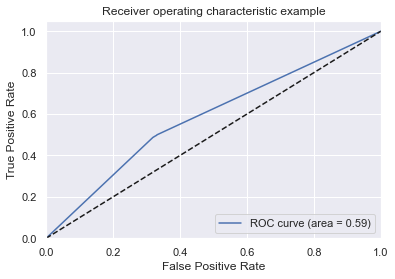

In [59]:
print("**** Running NaiveBayes Classifier with best parameter found using ML pipeline **** ")
# Create initial NaiveBayes model
nb_classifier = NaiveBayes(labelCol="label", featuresCol="features", smoothing=50, weightCol="weightColumn")
#nb_classifier = NaiveBayes(labelCol="label", featuresCol="pcaFeatures", smoothing=50, weightCol="weightColumn" )

# Train model with Training Data
nbModel = nb_classifier.fit(trainingSetDF)

# Make predictions on test data using the transform() method.
# NaiveBayes.transform() will only use the 'features' column.
predictions = nbModel.transform(testSetDF)

# Evaluate model
evaluator = MulticlassClassificationEvaluator( labelCol="label", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(predictions)

#print(nb_accuracy)

getEvaluationMatrix(predictions)

### Random Forest Classifier

**** Running Random Forest Classifier with best parameter found using ML pipeline **** 
totalCount   -  120300
correctCount -  119323
wrongCount   -  977
trueP        -  94572
trueN        -  24751
falseN       -  600
falseP       -  377
ratioWrong   -  0.008121363258520366
ratioCorrect -  0.9918786367414796
Accuracy     -  0.9918786367414796
Precision    -  99.60294473875449
Recall       -  99.3695624763586
F-1 Score    -  99.4861167361838
Sensitivity  -  99.3695624763586
Specificity  -  98.49968163005413


Exception ignored in: <function JavaModelWrapper.__del__ at 0x000001F544D10670>
Traceback (most recent call last):
  File "C:\Users\PHATHUTSHEDZO\anaconda3\lib\site-packages\pyspark\mllib\common.py", line 152, in __del__
    assert self._sc._gateway is not None
AttributeError: 'BinaryClassificationMetrics' object has no attribute '_sc'


ROC score is -  0.9996681532151581


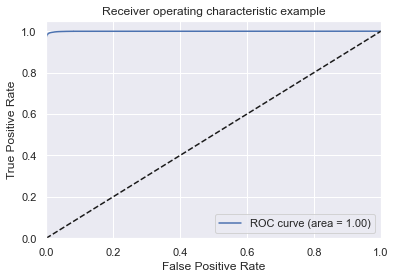

In [62]:
# Create initial Random Forest Classifier model
print("**** Running Random Forest Classifier with best parameter found using ML pipeline **** ")
rf_classifier = RandomForestClassifier( impurity="gini", maxDepth=12, numTrees=10, featureSubsetStrategy="auto", seed=1395)

# Train model with Training Data
rf_model = rf_classifier.fit(trainingSetDF)

# Print the Forest tree rules. 
#rf_model.toDebugString

# Make predictions on test data using the transform() method.
# RandomForest.transform() will only use the 'features' column.
predictions = rf_model.transform(testSetDF)

#predictions.show(5)

evaluator = MulticlassClassificationEvaluator( labelCol = "label" )
rf_accuracy = evaluator.evaluate(predictions)

#print("accuracy - ", rf_accuracy)

getEvaluationMatrix(predictions)

### Gradient Boosting Classifier

**** Running Gradient Boosting Classifier with best parameter found using ML pipeline **** 
totalCount   -  120300
correctCount -  120300
wrongCount   -  0
trueP        -  94949
trueN        -  25351
falseN       -  0
falseP       -  0
ratioWrong   -  0.0
ratioCorrect -  1.0
Accuracy     -  1.0
Precision    -  100.0
Recall       -  100.0
F-1 Score    -  100.0
Sensitivity  -  100.0
Specificity  -  100.0
ROC score is -  1.0


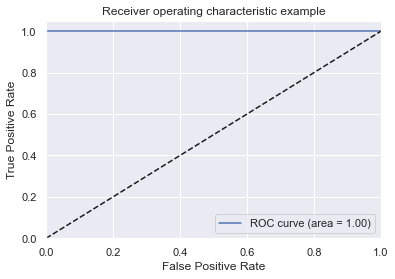

In [63]:


print("**** Running Gradient Boosting Classifier with best parameter found using ML pipeline **** ")

# Create initial Gradient Boosting Classifier model
gb_classifier = GBTClassifier(labelCol="label", featuresCol="features", maxDepth=5, maxBins=5, lossType="logistic", maxIter=10, stepSize=.00000001)
#gb_classifier = GBTClassifier(labelCol="label", featuresCol="pcaFeatures", maxDepth=1, maxBins=5, lossType="logistic", maxIter=1, stepSize=.00000001)

# Train model with Training Data
gbModel = gb_classifier.fit(trainingSetDF)

# Make predictions on test data using the transform() method.
# NaiveBayes.transform() will only use the 'features' column.
predictions = gbModel.transform(testSetDF)

# Evaluate model
evaluator = MulticlassClassificationEvaluator( labelCol="label", predictionCol="prediction", metricName="accuracy")
gb_accuracy = evaluator.evaluate(predictions)

#print(gb_accuracy)

getEvaluationMatrix(predictions)